# Notes

This project uses the Face Mask Detection dataset by Larxel (andrewmvd) from Kaggle. You can check the dataset link here: https://www.kaggle.com/andrewmvd/face-mask-detection


# # Install and Import Libraries

In order to get started, we must import all required libraries. This project is about face mask detection, so first we need to install the OpenCV library, one of the most common library for object detection.

In [14]:
# Data Manipulation
import pandas as pd

# Numerical Analysis
import numpy as np

# Data Visualization
from matplotlib import pyplot as plt
import seaborn as sns

# Operating System
import os

# Deep Learning and Object Detection
import tensorflow as tf
from tensorflow import keras
from keras.models import save_model, load_model
from keras_preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import cv2
from PIL import Image as PILImage
from keras.preprocessing import image as KerasImage

# Data Extraction
import glob
from xml.etree import ElementTree
import xmltodict

In [3]:
annotations_path = 'data/annotations/'
images_path = 'data/images/'
cropped_images_path = 'data/cropped_images/'
model_path = 'model/'

# Data Extraction

In [5]:
def getAnnotationsDf():
    all_annotations = []
    for annotation_file_path in glob.glob(annotations_path+'*.xml'):
        annotation_dict = xmltodict.parse(open(annotation_file_path,'rb'))
        faces = annotation_dict['annotation']['object'];
        if not isinstance(faces, list):
            faces = [faces]

        for faceNumberInImage,face in enumerate(faces):
            annotations_info={}
            annotations_info['filename'] = str(annotation_dict['annotation']['filename'])
            annotations_info['category'] = str(face['name'])
            annotations_info['xmin'] = int(face['bndbox']['xmin'])
            annotations_info['ymin'] = int(face['bndbox']['ymin'])
            annotations_info['xmax'] = int(face['bndbox']['xmax'])
            annotations_info['ymax'] = int(face['bndbox']['ymax'])
            annotations_info['height'] = int(annotation_dict['annotation']['size']['height'])
            annotations_info['width'] = int(annotation_dict['annotation']['size']['width'])
            annotations_info['faceNumberInImage'] = str(faceNumberInImage)
            all_annotations.append(annotations_info)
    df = pd.DataFrame(all_annotations)
    df['croppedImageFileName'] = df.apply(lambda row : row.filename.split('.')[0] +'_'+row.faceNumberInImage+'.png', axis =1)
    df.drop('faceNumberInImage',axis=1, inplace=True)
    return df
    

In [6]:
annotations_df = getAnnotationsDf()
# annotations_df.nunique(axis=0)
annotations_df.head(10)

,filename,category,xmin,ymin,xmax,ymax,height,width,croppedImageFileName
0,maksssksksss299.png,without_mask,62,194,160,320,400,301,maksssksksss299_0.png
1,maksssksksss528.png,without_mask,43,169,149,308,400,301,maksssksksss528_0.png
2,maksssksksss272.png,mask_weared_incorrect,48,107,218,304,400,275,maksssksksss272_0.png
3,maksssksksss514.png,with_mask,28,78,43,99,267,400,maksssksksss514_0.png
4,maksssksksss514.png,with_mask,160,66,176,83,267,400,maksssksksss514_1.png
5,maksssksksss514.png,with_mask,174,33,186,52,267,400,maksssksksss514_2.png
6,maksssksksss514.png,with_mask,202,40,216,59,267,400,maksssksksss514_3.png
7,maksssksksss514.png,without_mask,237,41,248,58,267,400,maksssksksss514_4.png
8,maksssksksss514.png,mask_weared_incorrect,249,44,266,66,267,400,maksssksksss514_5.png
9,maksssksksss514.png,with_mask,298,38,311,54,267,400,maksssksksss514_6.png


In [7]:
def readImage(annotation):
    image = cv2.cvtColor(cv2.imread(images_path+annotation.filename), cv2.COLOR_BGR2RGB)
    return image

def renderImage(image):
    plt.figure(figsize = (12, 8))
    plt.imshow(image)
    plt.show()
    
def drawBoundingBoxesInImage(annotation):
    image = readImage(annotation)
    start_point = (annotation.xmin, annotation.ymin)
    end_point = (annotation.xmax, annotation.ymax)
    cv2.rectangle(image, start_point, end_point, color = (255, 255, 0), thickness = 2)
    renderImage(image)
    
def cropFace(annotation):
    xmin = annotation.xmin
    ymin = annotation.ymin
    xmax = annotation.xmax
    ymax = annotation.ymax
    image = readImage(annotation)
    croppedFace = image[ymin:ymax, xmin:xmax]
    return croppedFace


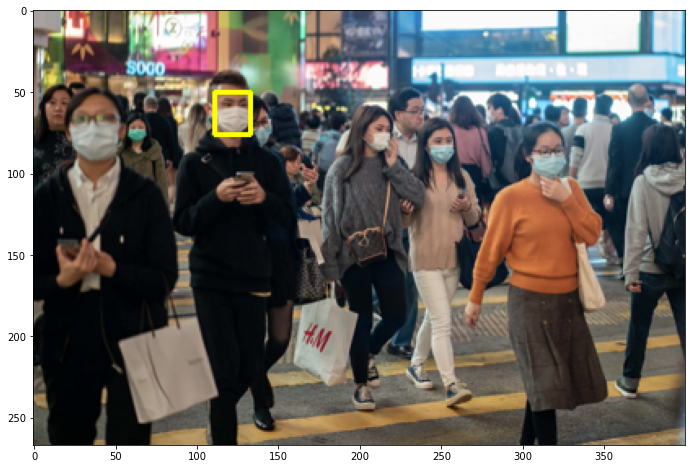

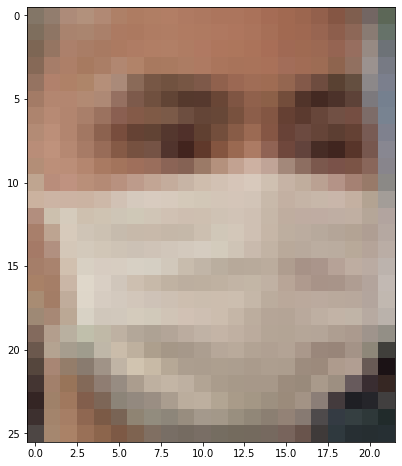

In [8]:
imageNumber = 99
drawBoundingBoxesInImage(annotations_df.loc[imageNumber])
# Displaying the Image in RGB
renderImage(cropFace(annotations_df.loc[imageNumber]))

# Crop & Save Faces

In [9]:
def cropAndSave(annotations_df: pd.DataFrame):
    if not os.path.exists(cropped_images_path):
        os.mkdir(cropped_images_path)
    for index, row in annotations_df.iterrows():
        croppedFace = cv2.cvtColor(cropFace(row), cv2.COLOR_BGR2RGB)
        croppedImagePath = os.path.join(cropped_images_path+row.croppedImageFileName)
        cv2.imwrite(croppedImagePath, croppedFace)
    print('Done!')
        
    

In [10]:
cropAndSave(annotations_df)

Done!


# Exploratory Analysis

In [11]:
target_categories =  list(annotations_df.category.unique())
print(target_categories)
annotations_df['category'].value_counts()

['without_mask', 'mask_weared_incorrect', 'with_mask']


with_mask                3232
without_mask              717
mask_weared_incorrect     123
Name: category, dtype: int64

In [17]:
sorted_label_df = pd.DataFrame(annotations_df['category'].value_counts()).reset_index()
sorted_label_df.rename(columns = {'index': 'category', 'category': 'count'}, inplace = True)
sorted_label_df

,category,count
0,with_mask,3232
1,without_mask,717
2,mask_weared_incorrect,123


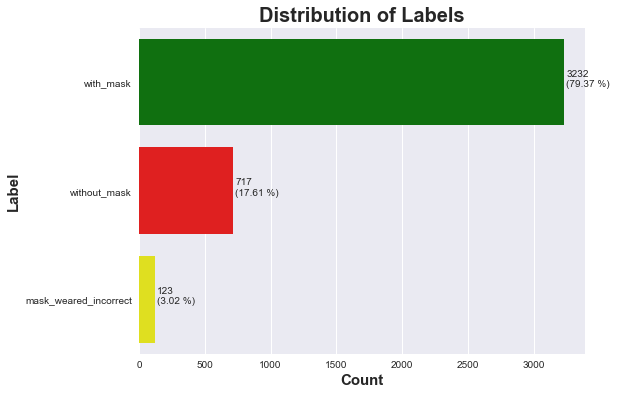

In [19]:
plt.style.use('seaborn')
plt.figure(figsize = (8, 6))
barplot = sns.barplot(x = 'count', y = 'category', data = sorted_label_df, orient = 'horizontal', 
                      palette = ['green', 'red', 'yellow'])
plt.title('Distribution of Labels', fontsize = 20, fontweight = 'bold')
plt.xlabel('Count', fontsize = 15, fontweight = 'bold')
plt.ylabel('Label', fontsize = 15, fontweight = 'bold')

for p in barplot.patches:
    width = p.get_width()
    percentage = round(width * 100 / sum(sorted_label_df['count']), 2)
    plt.text(x = width + 15, y = p.get_y() + 0.55 * p.get_height(), s = f'{int(width)}\n({percentage} %)')

plt.show()

In [20]:
def getHeightAndWidth(annotations: pd.DataFrame):
    cropped_image_width = []
    cropped_image_height = []
    for index, row in annotations.iterrows():
        cropped_image = cv2.imread(cropped_images_path+row.croppedImageFileName)
        cropped_image_height.append(cropped_image.shape[0])
        cropped_image_width.append(cropped_image.shape[1])

        
    annotations['cropped_width'] = cropped_image_width
    annotations['cropped_height'] = cropped_image_height
    return annotations


In [21]:
annotations_df = getHeightAndWidth(annotations_df)

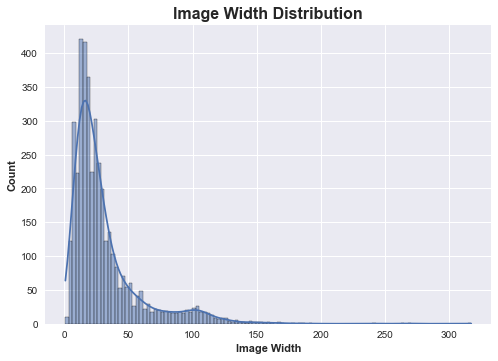

In [22]:
sns.histplot(annotations_df.cropped_width, kde = True)
plt.title('Image Width Distribution', fontsize = 16, fontweight = 'bold')
plt.xlabel('Image Width', fontweight = 'bold')
plt.ylabel('Count', fontweight = 'bold')
plt.show()

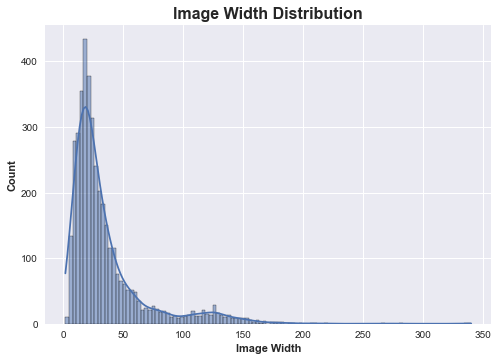

In [23]:
sns.histplot(annotations_df.cropped_height, kde = True)
plt.title('Image Width Distribution', fontsize = 16, fontweight = 'bold')
plt.xlabel('Image Width', fontweight = 'bold')
plt.ylabel('Count', fontweight = 'bold')
plt.show()

In [24]:
median_width = int(np.median(annotations_df.cropped_width))
median_height = int(np.median(annotations_df.cropped_height))
target_size = (median_width, median_height)
target_size


(22, 24)

# Train Test Split

Before proceeding into next steps, it's better for us to split the full data into training and testing data. For the testing (unseen) data, I will just take around 25% of the full dataset, and the rest are in the training data.

In [25]:
train_df, test_df = train_test_split(annotations_df, test_size=0.2,shuffle=True,random_state=42)
input_shape = [median_width, median_height, 3]
train_image_generator = ImageDataGenerator(rescale=1./255., validation_split=0.25)

train_data = train_image_generator.flow_from_dataframe(
    dataframe= train_df,
    directory= cropped_images_path,
    x_col= 'croppedImageFileName',
    y_col= 'category',
    subset= 'training',
    batch_size= 32,
    seed = 42,
    shuffle=False,
    class_mode='categorical',
    target_size =target_size,
)

validation_data = train_image_generator.flow_from_dataframe(
    dataframe= train_df,
    directory= cropped_images_path,
    x_col= 'croppedImageFileName',
    y_col= 'category',
    subset= 'validation',
    batch_size= 32,
    seed = 42,
    shuffle=False,
    class_mode='categorical',
    target_size =target_size,
)



test_image_generator = ImageDataGenerator(rescale=1./255.)

test_data = test_image_generator.flow_from_dataframe(
    dataframe= test_df,
    directory= cropped_images_path,
    x_col= 'croppedImageFileName',
    y_col= 'category',
    batch_size= 32,
    seed = 42,
    shuffle=False,
    class_mode='categorical',
    target_size =target_size,
    
)




Found 2443 validated image filenames belonging to 3 classes.
Found 814 validated image filenames belonging to 3 classes.
Found 815 validated image filenames belonging to 3 classes.


In [26]:
category_class_dict = {v: k for k, v in train_data.class_indices.items()}

category_class_dict

{0: 'mask_weared_incorrect', 1: 'with_mask', 2: 'without_mask'}

# Modelling

In [27]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters = 10, kernel_size = 3, activation = 'relu', 
                        input_shape = input_shape),
    keras.layers.Conv2D(filters = 10, kernel_size = 3, activation = 'relu'),
    keras.layers.MaxPool2D(pool_size = 2, padding = 'valid'),
    keras.layers.Conv2D(filters = 10, kernel_size = 3, activation = 'relu'),
    keras.layers.Conv2D(filters = 10, kernel_size = 3, activation = 'relu'),
    keras.layers.MaxPool2D(pool_size = 2, padding = 'valid'),
    keras.layers.Flatten(),
    keras.layers.Dense(units = len(target_categories), activation = 'softmax')
])

In [28]:
model.compile(loss = 'categorical_crossentropy',
                optimizer = keras.optimizers.Adam(),
                metrics = ['accuracy', keras.metrics.Recall()])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 20, 22, 10)        280       
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 20, 10)        910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 9, 10, 10)        0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 8, 10)          910       
                                                                 
 conv2d_3 (Conv2D)           (None, 5, 6, 10)          910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 3, 10)         0         
 2D)                                                    

In [30]:
history = model.fit(train_data, epochs = 15, steps_per_epoch = len(train_data), 
                        validation_data = validation_data, validation_steps = len(validation_data))



Epoch 1/15
77/77 [==============================] - 2s 18ms/step - loss: 0.6591 - accuracy: 0.7695 - recall: 0.6107 - val_loss: 0.4495 - val_accuracy: 0.8120 - val_recall: 0.8047
Epoch 2/15
77/77 [==============================] - 1s 16ms/step - loss: 0.4291 - accuracy: 0.8174 - recall: 0.7916 - val_loss: 0.3002 - val_accuracy: 0.9029 - val_recall: 0.8477
Epoch 3/15
77/77 [==============================] - 1s 15ms/step - loss: 0.3063 - accuracy: 0.9079 - recall: 0.8944 - val_loss: 0.2745 - val_accuracy: 0.9177 - val_recall: 0.9115
Epoch 4/15
77/77 [==============================] - 1s 16ms/step - loss: 0.2655 - accuracy: 0.9226 - recall: 0.9161 - val_loss: 0.2179 - val_accuracy: 0.9337 - val_recall: 0.9263
Epoch 5/15
77/77 [==============================] - 1s 15ms/step - loss: 0.2397 - accuracy: 0.9316 - recall: 0.9239 - val_loss: 0.1920 - val_accuracy: 0.9324 - val_recall: 0.9275
Epoch 6/15
77/77 [==============================] - 1s 15ms/step - loss: 0.2119 - accuracy: 0.9361 - reca

In [31]:
result = pd.DataFrame(history.history)
result

,loss,accuracy,recall,val_loss,val_accuracy,val_recall
0,0.659082,0.769546,0.610725,0.449545,0.812039,0.804668
1,0.429079,0.817438,0.791650,0.300216,0.902948,0.847666
2,0.306336,0.907900,0.894392,0.274494,0.917690,0.911548
3,0.265537,0.922636,0.916087,0.217916,0.933661,0.926290
4,0.239726,0.931641,0.923864,0.192019,0.932432,0.927518
5,0.211858,0.936144,0.930823,0.200518,0.936118,0.921376
6,0.199599,0.936963,0.930823,0.170465,0.942260,0.937346
7,0.186407,0.942284,0.937372,0.171853,0.943489,0.939803
8,0.183276,0.939009,0.934097,0.183055,0.942260,0.931204
9,0.175490,0.941465,0.937372,0.168781,0.944717,0.939803


<AxesSubplot:>

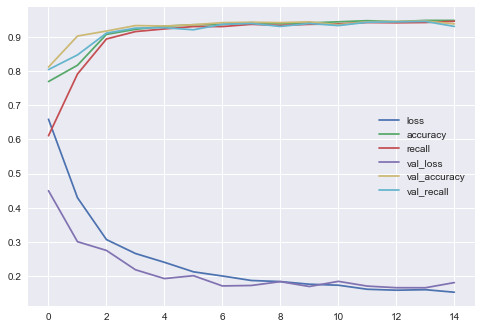

In [32]:
result.plot()

In [33]:
def plot_line(result, ax, col, title, train_column, valid_column):
    # Line Plot of Model Performance
    ax[col].plot(result[train_column])
    ax[col].plot(result[valid_column])
    
    # Title and Legend
    ax[col].set_title(title, fontweight = 'bold')
    ax[col].legend(['Train', 'Validation'])
    
def plot_result(result, train_recall, valid_recall):
    # Create a 1x3 Grid and Set Main Title
    fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (17, 8))
    fig.suptitle('Model Performance', fontsize = 20, fontweight = 'bold')
    
    # Visualization of Accuracy, Recall, and Loss
    plot_line(result, ax, 0, 'Accuracy', 'accuracy', 'val_accuracy')
    plot_line(result, ax, 1, 'Recall', train_recall, valid_recall)
    plot_line(result, ax, 2, 'Loss', 'loss', 'val_loss')
    plt.show()

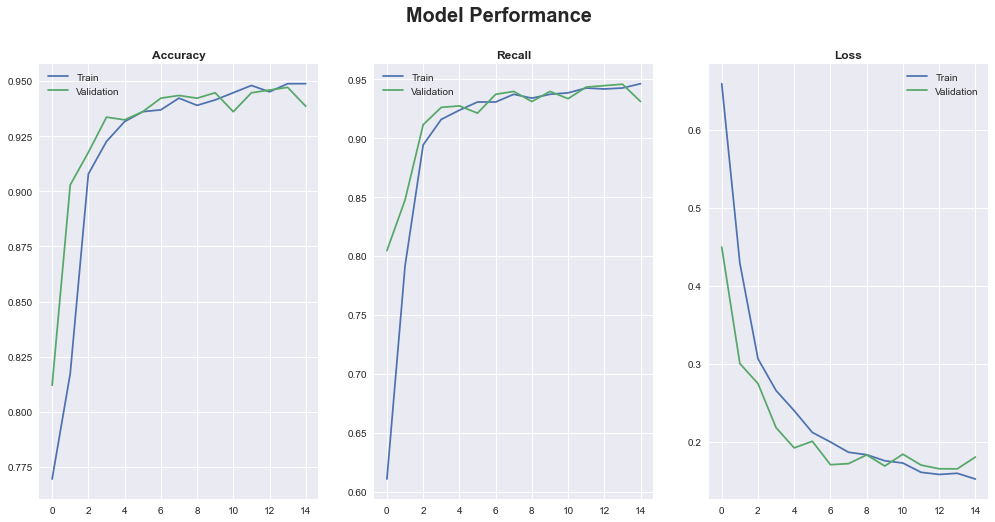

In [34]:
plot_result(result, 'recall', 'val_recall')

In [35]:
#Save Model
save_model(model,model_path)

INFO:tensorflow:Assets written to: model/assets


In [36]:
loaded_model = load_model(model_path, compile = True)
test_result = np.argmax(loaded_model.predict(test_data),axis =1)

In [37]:
final_test_df = test_df
final_test_df['prediction'] = test_result
final_test_df['prediction'] = final_test_df.apply(lambda row : category_class_dict[row.prediction], axis=1)
final_test_df

,filename,category,xmin,ymin,xmax,ymax,height,width,croppedImageFileName,cropped_width,cropped_height,prediction
605,maksssksksss117.png,with_mask,131,224,227,346,400,301,maksssksksss117_0.png,96,122,with_mask
744,maksssksksss19.png,without_mask,161,20,195,54,236,400,maksssksksss19_2.png,34,34,without_mask
1723,maksssksksss374.png,with_mask,28,91,52,113,240,400,maksssksksss374_1.png,24,22,with_mask
1703,maksssksksss176.png,mask_weared_incorrect,237,86,277,135,225,400,maksssksksss176_7.png,40,49,with_mask
408,maksssksksss516.png,with_mask,254,78,284,108,225,400,maksssksksss516_4.png,30,30,with_mask
...,...,...,...,...,...,...,...,...,...,...,...,...
1157,maksssksksss41.png,with_mask,283,203,315,235,281,400,maksssksksss41_7.png,32,32,with_mask
221,maksssksksss529.png,without_mask,170,89,182,103,226,400,maksssksksss529_2.png,12,14,without_mask
2528,maksssksksss801.png,with_mask,311,97,320,108,295,400,maksssksksss801_5.png,9,11,with_mask
3742,maksssksksss256.png,with_mask,380,32,400,54,268,400,maksssksksss256_12.png,20,22,with_mask


In [38]:
final_test_df.category.value_counts()

with_mask                627
without_mask             160
mask_weared_incorrect     28
Name: category, dtype: int64

In [39]:
final_test_df.prediction.value_counts()

with_mask                660
without_mask             139
mask_weared_incorrect     16
Name: prediction, dtype: int64

In [40]:
prediction_Model = load_model(model_path)
prediction_Model.compile(loss = 'categorical_crossentropy',
                optimizer = keras.optimizers.Adam(),
                metrics = ['accuracy', keras.metrics.Recall()])

# Real Time Prediction

In [1]:
# Data Manipulation
import pandas as pd

# Numerical Analysis
import numpy as np

# Deep Learning and Object Detection
import tensorflow as tf
from tensorflow import keras
from keras.models import save_model, load_model
from keras_preprocessing.image import ImageDataGenerator
import cv2
from PIL import Image as PILImage
from keras.preprocessing import image as KerasImage
import time

from mtcnn.mtcnn import MTCNN
model_path = 'model/'
category_class_dict = {0: 'Mask Worn Incorrectly', 1: 'With Mask', 2: 'Without Mask'}
prediction_Model = load_model(model_path)
prediction_Model.compile(loss = 'categorical_crossentropy',
                optimizer = keras.optimizers.Adam(),
                metrics = ['accuracy', keras.metrics.Recall()])

detector = MTCNN()
videoCapture = cv2.VideoCapture(0)
while True:
    # Capture frame-by-frame
    ret, frame = videoCapture.read()
    frame_RGB = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    faces = detector.detect_faces(frame)
    for result in faces:
        x, y, w, h = result['box']
        x1, y1 = x + w, y + h
        
        cropped_img = frame_RGB[y:y1, x:x1]
        resizedCroppedImage = PILImage.fromarray(cropped_img).resize((24,22))
        imageToPredict = np.expand_dims(KerasImage.img_to_array(resizedCroppedImage), axis=0)
        
        predicted_class = np.argmax(prediction_Model.predict(imageToPredict),axis =1).tolist()[0]
        prediction = category_class_dict[predicted_class]
        
        if predicted_class == 0:
            cv2.rectangle(frame, (x, y), (x1, y1), (0,255,255), 2)
            cv2.putText(frame, prediction, (x,y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1,(0,255,255), 2)
        
        elif predicted_class == 1:
            cv2.rectangle(frame, (x, y), (x1, y1), (0,255,0), 2)
            cv2.putText(frame, prediction, (x,y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1,(0,255,0), 2)
            
        elif predicted_class == 2:
            cv2.rectangle(frame, (x, y), (x1, y1), (0,0,255), 2)
            cv2.putText(frame, prediction, (x,y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1,(0,0,255), 2)
        
    cv2.imshow('Video', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything is done, release the captureq
videoCapture.release()
cv2.destroyAllWindows()

